In [1]:
import json
import os
import math
import librosa
import numpy as np
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATASET_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
JSON_PATH = "/kaggle/working/All_Data.json"
Model_PATH = "/kaggle/working/Model.keras"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

2024-02-07 17:11:14.872672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 17:11:14.872786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 17:11:15.009573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:
                try:
		# load audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                    for d in range(num_segments):

                    # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                    # extract mfcc
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                except:
                      print("An exception occurred")

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [4]:
def load_data(dataset_path):
    with open(dataset_path,"r") as fp:
        data = json.load(fp)
    x = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print("Data succesfully loaded!")
    return x,y

In [5]:
def plot_history(history):
    fig,axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("error")    
    axs[1].set_xlabel("epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()


In [6]:
def prepare_datasets(X,Y,test_size=0.25,validation_size=0.2):
    x_train,x_test,y_train,y_test=  train_test_split(X,Y,test_size=test_size)
    x_train ,x_validation,y_train,y_validation= train_test_split(x_train,y_train,test_size=validation_size)
    return x_train,x_validation,x_test,y_train,y_validation,y_test

In [15]:
def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(256,input_shape=input_shape,return_sequences=True))
    model.add(keras.layers.LSTM(64))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10,activation='softmax'))
    return model

Data succesfully loaded!
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 130, 256)          276480    
                                                                 
 lstm_8 (LSTM)               (None, 64)                82176     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 363466 (1.39 MB)
Trainable params: 363466 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________

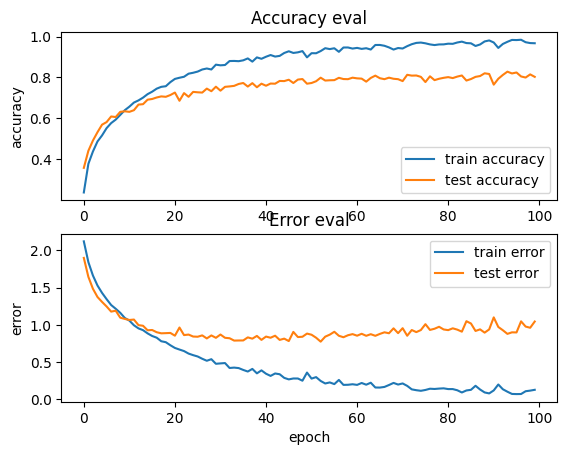

In [16]:
x,y= load_data(JSON_PATH)
x_train,x_validation,x_test,y_train,y_validation,y_test = prepare_datasets(x,y)
input_shape = (x_train.shape[1],x_train.shape[2])
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,validation_data = ( x_validation,y_validation),batch_size = 32,epochs = 100)
model.save(Model_PATH)
test_error,test_accuracy=model.evaluate(x_test,y_test)
print('error = {}'.format(test_error))
print('accuracy = {}'.format(test_accuracy))
plot_history(history)